### Try to fit different models to behavior

In [12]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import scipy
import pickle
import matplotlib.pyplot as plt
from models.rw_model import RWModel, calc_values_for_rw_model
from models.td_model import TDModel, calc_values_for_td_model
from model_fit_utils import (
    fit_rw_model, 
    calc_rw_value_mse, 
    calc_rw_rpe_mse, 
    fit_td_model,
    calc_td_value_mse,
    calc_td_rpe_mse,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load some data

In [13]:
# file name -> (behavior)

# just always 0, 1, 2. 8 of each 
stim_idxs = np.concatenate([np.zeros(8), np.ones(8), np.ones(8) * 2]).astype(int)
rewards = np.concatenate([np.ones(16) * -1, np.zeros(8)])

mean_data = {}

for file_name in os.listdir("data/scr"):
    ve = scipy.io.loadmat(f"data/scr/{file_name}")
    src_csr_all = ve["phase1_scr_stim_all"][0]
    means = [np.mean(el, axis=0) for el in src_csr_all]
    data = np.concatenate(means)
    data_min = np.min(data)
    data_max = np.max(data)
    scaled = (data - data_min) / (data_max - data_min) * -1
    mean_data[file_name] = scaled

In [14]:
time_series_data = {}
# want data to be: num_trials x num_timesteps
for file_name in os.listdir("data/scr"):
    ve = scipy.io.loadmat(f"data/scr/{file_name}")
    src_csr_all = ve["phase1_scr_stim_all"][0]
    data = np.hstack([el for el in src_csr_all]).T
    data_min = np.min(data)
    data_max = np.max(data)
    scaled = (data - data_min) / (data_max - data_min) * -1
    time_series_data[file_name] = scaled

In [15]:
time_series_data["VE103.mat"].shape

(24, 60)

### Fit to Value and RPE to RW Model

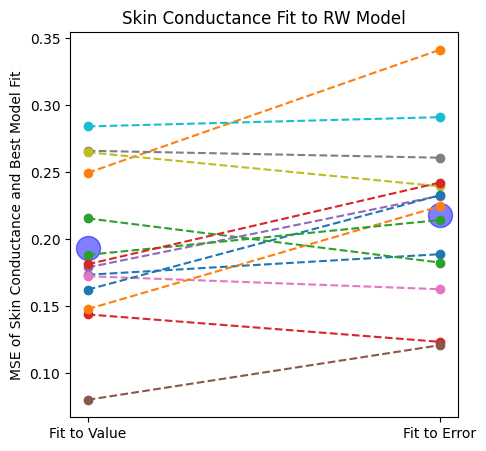

In [16]:
rw_phase_1_results = {}
fig, ax = plt.subplots(figsize=(5, 5))
vals = []
rpes = []
for file_name in mean_data:
    data = mean_data[file_name]
    value_fit = fit_rw_model(calc_rw_value_mse, stim_idxs, rewards, data, 0.5)
    rpe_fit = fit_rw_model(calc_rw_rpe_mse, stim_idxs, rewards, data, 0.5)
    vals.append(value_fit.fun)
    rpes.append(rpe_fit.fun)
    rw_phase_1_results[file_name] = (value_fit, rpe_fit)

    ax.plot([0, 1], [value_fit.fun, rpe_fit.fun], "--o", label=file_name.split(".")[0])

val_mean = np.mean(vals)
rpe_mean = np.mean(rpes)
ax.scatter([0, 1], [val_mean, rpe_mean], s=300, alpha=0.5, c="b")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Fit to Value", "Fit to Error"])
ax.set_ylabel("MSE of Skin Conductance and Best Model Fit")
ax.set_title("Skin Conductance Fit to RW Model")

with open('data/rw_phase_1_results.pickle', 'wb') as handle:
    pickle.dump(rw_phase_1_results, handle)
    

### Fit Value and RPE to TD Model

In [17]:
td_phase_1_results = {}

for file_name in time_series_data:
    data = time_series_data[file_name]
    value_fit, value_k = fit_td_model(calc_td_value_mse, stim_idxs, rewards, data, 0.5)
    rpe_fit, rpe_k = fit_td_model(calc_td_rpe_mse, stim_idxs, rewards, data, 0.5)
    td_phase_1_results[file_name] = (value_fit, value_k, rpe_fit, rpe_k)

with open('data/td_phase_1_results.pickle', 'wb') as handle:
    pickle.dump(td_phase_1_results, handle)

Text(0.5, 1.0, 'Skin Conductance Fit to TD Model')

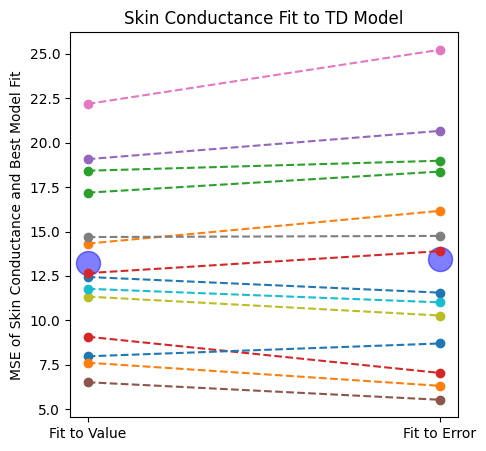

In [18]:
with open('data/td_phase_1_results.pickle', 'rb') as handle:
    td_phase_1_results = pickle.load(handle)
fig, ax = plt.subplots(figsize=(5, 5))
vals = []
rpes = []
for file_name in td_phase_1_results:
    value_fit, value_k, rpe_fit, rpe_k = td_phase_1_results[file_name]
    ax.plot([0, 1], [value_fit.fun, rpe_fit.fun], "--o", label=file_name.split(".")[0])
    vals.append(value_fit.fun)
    rpes.append(rpe_fit.fun)
val_mean = np.mean(vals)
rpe_mean = np.mean(rpes)
ax.scatter([0, 1], [val_mean, rpe_mean], s=300, alpha=0.5, c="b")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Fit to Value", "Fit to Error"])
ax.set_ylabel("MSE of Skin Conductance and Best Model Fit")
ax.set_title("Skin Conductance Fit to TD Model")


### See if Learning Rates are consistent across both models

Text(0, 0.5, 'Learning Rate')

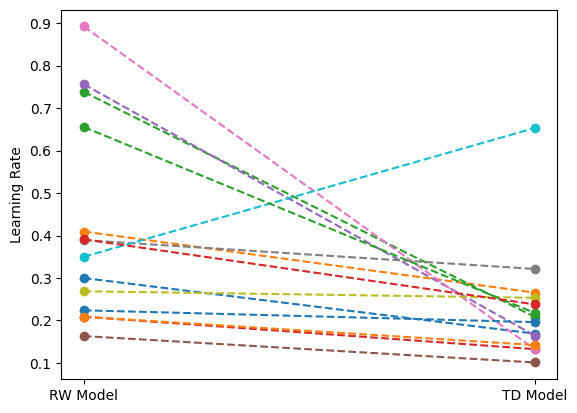

In [124]:
fig, ax = plt.subplots()
for file_name in td_results:
    value_fit_td, _, _, _ = td_results[file_name]
    data = mean_data[file_name]
    value_fit_rw = fit_rw_model(calc_rw_value_mse, stim_idxs, rewards, data, 0.5)
    ax.plot([0, 1], [value_fit_td.x[0], value_fit_rw.x[0]], "--o", label=file_name.split(".")[0])
ax.set_xticks([0, 1])
ax.set_xticklabels(["RW Model", "TD Model"])
ax.set_ylabel("Learning Rate")

### Now Look at vicarious extinction phase, load some data

In [19]:
stim_idxs = np.concatenate([np.zeros(8), np.ones(8), np.ones(8) * 2]).astype(int)
rewards = np.concatenate([np.ones(16) * -1, np.zeros(8)])

In [20]:
# file name -> (behavior)

# stim idxs are the same, just always 0, 1, 2. 8 of each stim. 
stim_idxs = np.concatenate([np.zeros(8), np.ones(8), np.ones(8) * 2]).astype(int)
# ASSUMPTION: vicarious rewards are also -1, treated exact same as actual rewards
# make CSR -1, CSS now 0, CSS- still 0
rewards = np.concatenate([np.ones(8) * -1, np.zeros(16)])

mean_data = {}

for file_name in os.listdir("data/scr"):
    ve = scipy.io.loadmat(f"data/scr/{file_name}")
    src_csr_all = ve["phase2_scr_stim_all"][0]
    means = [np.mean(el, axis=0) for el in src_csr_all]
    data = np.concatenate(means)
    data_min = np.min(data)
    data_max = np.max(data)
    scaled = (data - data_min) / (data_max - data_min) * -1
    mean_data[file_name] = scaled

### Fit RW models to phase 2 SCR data

In [22]:
# initialize values during extinction phase: 
# CSS, CSR intialized to -1, CS- to 0
init_vals = [-1, -1, 0]
rw_phase_2_results = {}
for file_name in mean_data:
    data = mean_data[file_name]
    value_fit = fit_rw_model(calc_rw_value_mse, stim_idxs, rewards, data, 0.5, init_vals=init_vals)
    rpe_fit = fit_rw_model(calc_rw_rpe_mse, stim_idxs, rewards, data, 0.5, init_vals=init_vals)
    rw_phase_2_results[file_name] = (value_fit, rpe_fit)

with open('data/rw_phase_2_results.pickle', 'wb') as handle:
    pickle.dump(rw_phase_2_results, handle)


    

### Plot Learning Rate comparisons

Text(0.5, 1.0, 'Different in learning rates during aquisition and extinction')

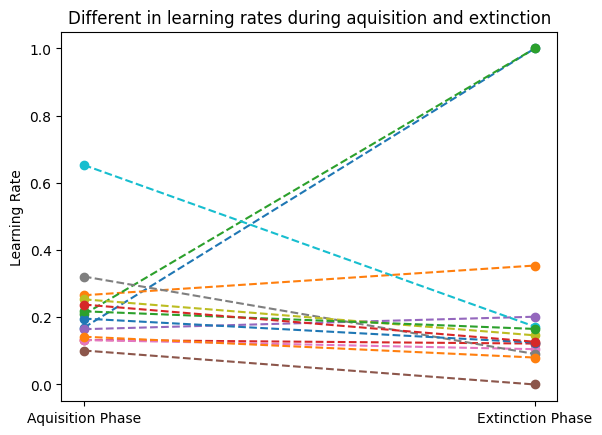

In [24]:
fig, ax = plt.subplots()

for file_name in mean_data:
    phase_1_alpha = rw_phase_1_results[file_name][0].x[0]
    phase_2_alpha = rw_phase_2_results[file_name][0].x[0]
    ax.plot([0, 1], [phase_1_alpha, phase_2_alpha], "--o", label=file_name.split(".")[0])
ax.set_xticks([0, 1])
ax.set_xticklabels(["Aquisition Phase", "Extinction Phase"])
ax.set_ylabel("Learning Rate")
ax.set_title("Different in learning rates during aquisition and extinction")

### Plot model fit comparisons

Text(0.5, 1.0, 'Difference in goodness of fit during aquisition and extinction')

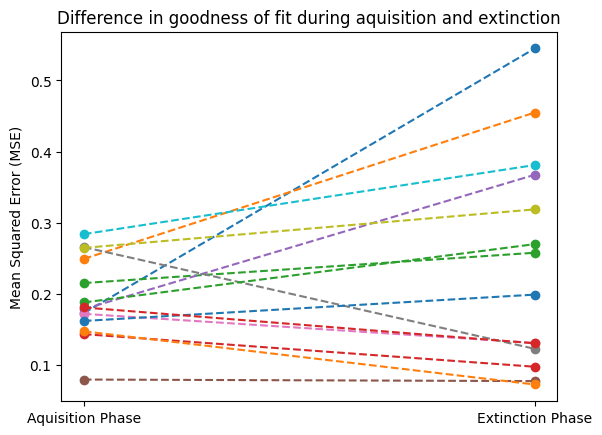

In [25]:
# compare 
fig, ax = plt.subplots()

for file_name in mean_data:
    phase_1_mse = rw_phase_1_results[file_name][0].fun
    phase_2_mse = rw_phase_2_results[file_name][0].fun
    ax.plot([0, 1], [phase_1_mse, phase_2_mse], "--o", label=file_name.split(".")[0])
ax.set_xticks([0, 1])
ax.set_xticklabels(["Aquisition Phase", "Extinction Phase"])
ax.set_ylabel("Mean Squared Error (MSE)")
ax.set_title("Difference in goodness of fit during aquisition and extinction")